In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from scipy import signal
from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot
from pmdarima.arima.utils import ndiffs
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
from pmdarima import acf
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from IPython.display import display, Markdown
from IPython.display import Math
import datetime
import math
from sklearn.metrics import mean_squared_error
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=ValueError)

In [23]:
df = pd.read_csv('G:/My Drive/eo_context.csv')
df = df.drop(columns=['b_competitive_S', 'b_competitive_I'])
df_spend = df.drop(columns=['display_I', 'b_branded_I', 'b_category_I', 'p_auto_I',
                            'p_auto_comp_I', 'p_brand_I', 'p_category_I', 'p_competitive_I'])
df_context =  df_spend.drop(columns=['display_S', 'b_branded_S', 'b_category_S', 'p_auto_S',
                                     'p_auto_comp_S', 'p_brand_S', 'p_category_S', 'p_competitive_S'])
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DATE             182 non-null    object 
 1   display_S        183 non-null    float64
 2   display_I        183 non-null    int64  
 3   b_branded_S      183 non-null    float64
 4   b_branded_I      183 non-null    int64  
 5   b_category_S     183 non-null    float64
 6   b_category_I     183 non-null    int64  
 7   p_auto_S         183 non-null    float64
 8   p_auto_I         183 non-null    int64  
 9   p_brand_S        183 non-null    float64
 10  p_brand_I        183 non-null    int64  
 11  p_category_S     183 non-null    float64
 12  p_category_I     183 non-null    int64  
 13  p_competitive_S  183 non-null    float64
 14  p_competitive_I  183 non-null    int64  
 15  revenue          182 non-null    float64
 16  p_auto_comp_S    182 non-null    float64
 17  p_auto_comp_I   

In [24]:
print('Missing Values')
print(df.isnull().sum() / len(df) * 100)
print('Zeroes')
print((df == 0).sum())

Missing Values
DATE               0.546448
display_S          0.000000
display_I          0.000000
b_branded_S        0.000000
b_branded_I        0.000000
b_category_S       0.000000
b_category_I       0.000000
p_auto_S           0.000000
p_auto_I           0.000000
p_brand_S          0.000000
p_brand_I          0.000000
p_category_S       0.000000
p_category_I       0.000000
p_competitive_S    0.000000
p_competitive_I    0.000000
revenue            0.546448
p_auto_comp_S      0.546448
p_auto_comp_I      0.546448
deaths             0.546448
hospital           0.546448
positive           0.546448
lockdown           0.546448
inflation          0.546448
gdp                0.546448
dtype: float64
Zeroes
DATE                 0
display_S           46
display_I           46
b_branded_S         12
b_branded_I         11
b_category_S        32
b_category_I        32
p_auto_S            37
p_auto_I            36
p_brand_S           10
p_brand_I           10
p_category_S        10
p_category_I   

In [6]:
df.nunique()

DATE               182
display_S          137
display_I          137
b_branded_S        171
b_branded_I        172
b_category_S       151
b_category_I       151
b_competitive_S      1
b_competitive_I      1
p_auto_S           144
p_auto_I           147
p_brand_S          173
p_brand_I          173
p_category_S       173
p_category_I       173
p_competitive_S    173
p_competitive_I    173
revenue            182
p_auto_comp_S      173
p_auto_comp_I      173
deaths              55
hospital            52
positive            61
lockdown             2
inflation           25
gdp                 15
dtype: int64

In [25]:
df.describe()

,display_S,display_I,b_branded_S,b_branded_I,b_category_S,b_category_I,p_auto_S,p_auto_I,p_brand_S,p_brand_I,...,p_competitive_I,revenue,p_auto_comp_S,p_auto_comp_I,deaths,hospital,positive,lockdown,inflation,gdp
count,183.000000,1.830000e+02,183.000000,183.000000,183.000000,183.000000,183.000000,1.830000e+02,183.000000,1.830000e+02,...,1.830000e+02,182.000000,182.000000,1.820000e+02,1.820000e+02,182.000000,1.820000e+02,182.000000,182.000000,182.000000
mean,4637.809836,1.285262e+06,441.744208,26384.901639,1898.278033,137039.732240,2760.283497,1.345672e+06,2490.680765,1.614725e+05,...,3.234888e+05,91366.699286,4238.062418,1.666118e+06,4.032230e+05,113425.351648,1.868622e+07,0.137363,3.462637,21864.246830
std,5312.400871,1.613741e+06,636.776145,73730.887323,1939.786116,180687.219838,2873.912725,1.500344e+06,2148.022670,1.674408e+05,...,4.053955e+05,31762.445743,4120.518939,1.798209e+06,8.209663e+05,217336.928839,4.489726e+07,0.345179,2.079957,5603.241146
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,...,0.000000e+00,7312.860000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,0.050000,1.150000e+01,98.445000,4455.000000,334.610000,12643.500000,110.485000,6.542550e+04,977.620000,7.635600e+04,...,7.486950e+04,71031.272500,433.640000,1.730890e+05,0.000000e+00,0.000000,0.000000e+00,0.000000,1.600000,21538.032000
50%,3806.780000,9.745630e+05,288.150000,8304.000000,1130.220000,95612.000000,1820.870000,6.537560e+05,1681.400000,1.055920e+05,...,1.421150e+05,93290.020000,2808.960000,7.985630e+05,0.000000e+00,0.000000,0.000000e+00,0.000000,2.700000,22680.392000
75%,5692.890000,1.708882e+06,458.425000,19216.000000,2992.230000,141432.500000,4814.790000,2.514310e+06,3679.865000,1.885920e+05,...,3.852125e+05,109470.380000,6891.107500,3.174060e+06,3.000092e+05,208396.000000,5.757527e+06,0.000000,5.900000,24740.480000
max,42909.000000,1.519961e+07,4209.840000,858625.000000,9002.000000,923563.000000,12808.270000,6.897577e+06,11216.000000,1.121810e+06,...,1.886733e+06,174302.250000,17665.110000,7.992118e+06,3.571866e+06,916174.000000,2.000848e+08,1.000000,6.600000,26137.992000


In [12]:
df_spend.describe()

,display_S,b_branded_S,b_category_S,b_competitive_S,p_auto_S,p_auto_I,p_brand_S,p_category_S,p_competitive_S,revenue,p_auto_comp_S,p_auto_comp_I,deaths,hospital,positive,lockdown,inflation,gdp
count,182.000000,182.000000,182.000000,182.0,182.000000,1.820000e+02,182.000000,182.000000,182.000000,182.000000,182.000000,1.820000e+02,1.820000e+02,182.000000,1.820000e+02,182.000000,182.000000,182.000000
mean,4427.528571,439.231813,1859.246593,0.0,2767.059780,1.346256e+06,2442.739451,13029.885055,1471.002637,91366.699286,4238.062418,1.666118e+06,4.032230e+05,113425.351648,1.868622e+07,0.137363,3.462637,21864.246830
std,4498.987018,637.622616,1871.690873,0.0,2880.374426,1.504462e+06,2053.428280,7409.538899,1546.598315,31762.445743,4120.518939,1.798209e+06,8.209663e+05,217336.928839,4.489726e+07,0.345179,2.079957,5603.241146
min,0.000000,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,7312.860000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,0.025000,98.222500,322.820000,0.0,76.892500,4.867775e+04,960.895000,8671.455000,322.210000,71031.272500,433.640000,1.730890e+05,0.000000e+00,0.000000,0.000000e+00,0.000000,1.600000,21538.032000
50%,3799.055000,286.820000,1110.425000,0.0,1826.180000,6.489980e+05,1679.130000,12021.545000,815.975000,93290.020000,2808.960000,7.985630e+05,0.000000e+00,0.000000,0.000000e+00,0.000000,2.700000,22680.392000
75%,5631.165000,454.297500,2927.725000,0.0,4832.755000,2.535610e+06,3534.770000,16731.617500,2139.602500,109470.380000,6891.107500,3.174060e+06,3.000092e+05,208396.000000,5.757527e+06,0.000000,5.900000,24740.480000
max,24634.650000,4209.840000,8287.340000,0.0,12808.270000,6.897577e+06,8513.440000,49020.900000,6163.160000,174302.250000,17665.110000,7.992118e+06,3.571866e+06,916174.000000,2.000848e+08,1.000000,6.600000,26137.992000


In [15]:
df_context.describe()

,p_auto_S,p_auto_I,revenue,p_auto_comp_S,p_auto_comp_I,deaths,hospital,positive,lockdown,inflation,gdp
count,182.000000,1.820000e+02,182.000000,182.000000,1.820000e+02,1.820000e+02,182.000000,1.820000e+02,182.000000,182.000000,182.000000
mean,2767.059780,1.346256e+06,91366.699286,4238.062418,1.666118e+06,4.032230e+05,113425.351648,1.868622e+07,0.137363,3.462637,21864.246830
std,2880.374426,1.504462e+06,31762.445743,4120.518939,1.798209e+06,8.209663e+05,217336.928839,4.489726e+07,0.345179,2.079957,5603.241146
min,0.000000,0.000000e+00,7312.860000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,76.892500,4.867775e+04,71031.272500,433.640000,1.730890e+05,0.000000e+00,0.000000,0.000000e+00,0.000000,1.600000,21538.032000
50%,1826.180000,6.489980e+05,93290.020000,2808.960000,7.985630e+05,0.000000e+00,0.000000,0.000000e+00,0.000000,2.700000,22680.392000
75%,4832.755000,2.535610e+06,109470.380000,6891.107500,3.174060e+06,3.000092e+05,208396.000000,5.757527e+06,0.000000,5.900000,24740.480000
max,12808.270000,6.897577e+06,174302.250000,17665.110000,7.992118e+06,3.571866e+06,916174.000000,2.000848e+08,1.000000,6.600000,26137.992000


,display_S,display_I,b_branded_S,b_branded_I,b_category_S,b_category_I,p_auto_S,p_auto_I,p_brand_S,p_brand_I,...,p_competitive_I,revenue,p_auto_comp_S,p_auto_comp_I,deaths,hospital,positive,lockdown,inflation,gdp
count,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,...,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000
mean,0.073913,-0.045652,0.263478,0.246522,0.067826,0.091304,0.425652,0.438696,0.435217,0.431304,...,0.395217,0.405217,0.451739,0.449565,0.340000,0.322609,0.348696,0.153043,-0.193478,-0.167826
std,0.346105,0.399816,0.358312,0.353677,0.388200,0.390993,0.497465,0.489910,0.397113,0.411508,...,0.428123,0.279136,0.498504,0.494152,0.492018,0.485885,0.492446,0.393347,0.473062,0.477779
min,-0.380000,-0.480000,-0.470000,-0.480000,-0.450000,-0.540000,-0.610000,-0.590000,-0.420000,-0.410000,...,-0.400000,-0.190000,-0.590000,-0.550000,-0.630000,-0.630000,-0.640000,-0.510000,-0.640000,-0.610000
25%,-0.155000,-0.365000,0.105000,0.080000,-0.150000,-0.160000,0.255000,0.230000,0.220000,0.155000,...,0.175000,0.225000,0.255000,0.230000,0.060000,0.050000,0.105000,-0.195000,-0.545000,-0.515000
50%,0.020000,-0.110000,0.240000,0.240000,-0.040000,0.080000,0.580000,0.610000,0.550000,0.660000,...,0.520000,0.460000,0.600000,0.620000,0.520000,0.490000,0.480000,0.270000,-0.380000,-0.320000
75%,0.170000,0.095000,0.475000,0.420000,0.305000,0.305000,0.730000,0.760000,0.715000,0.710000,...,0.740000,0.520000,0.790000,0.800000,0.615000,0.590000,0.650000,0.420000,-0.075000,0.050000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


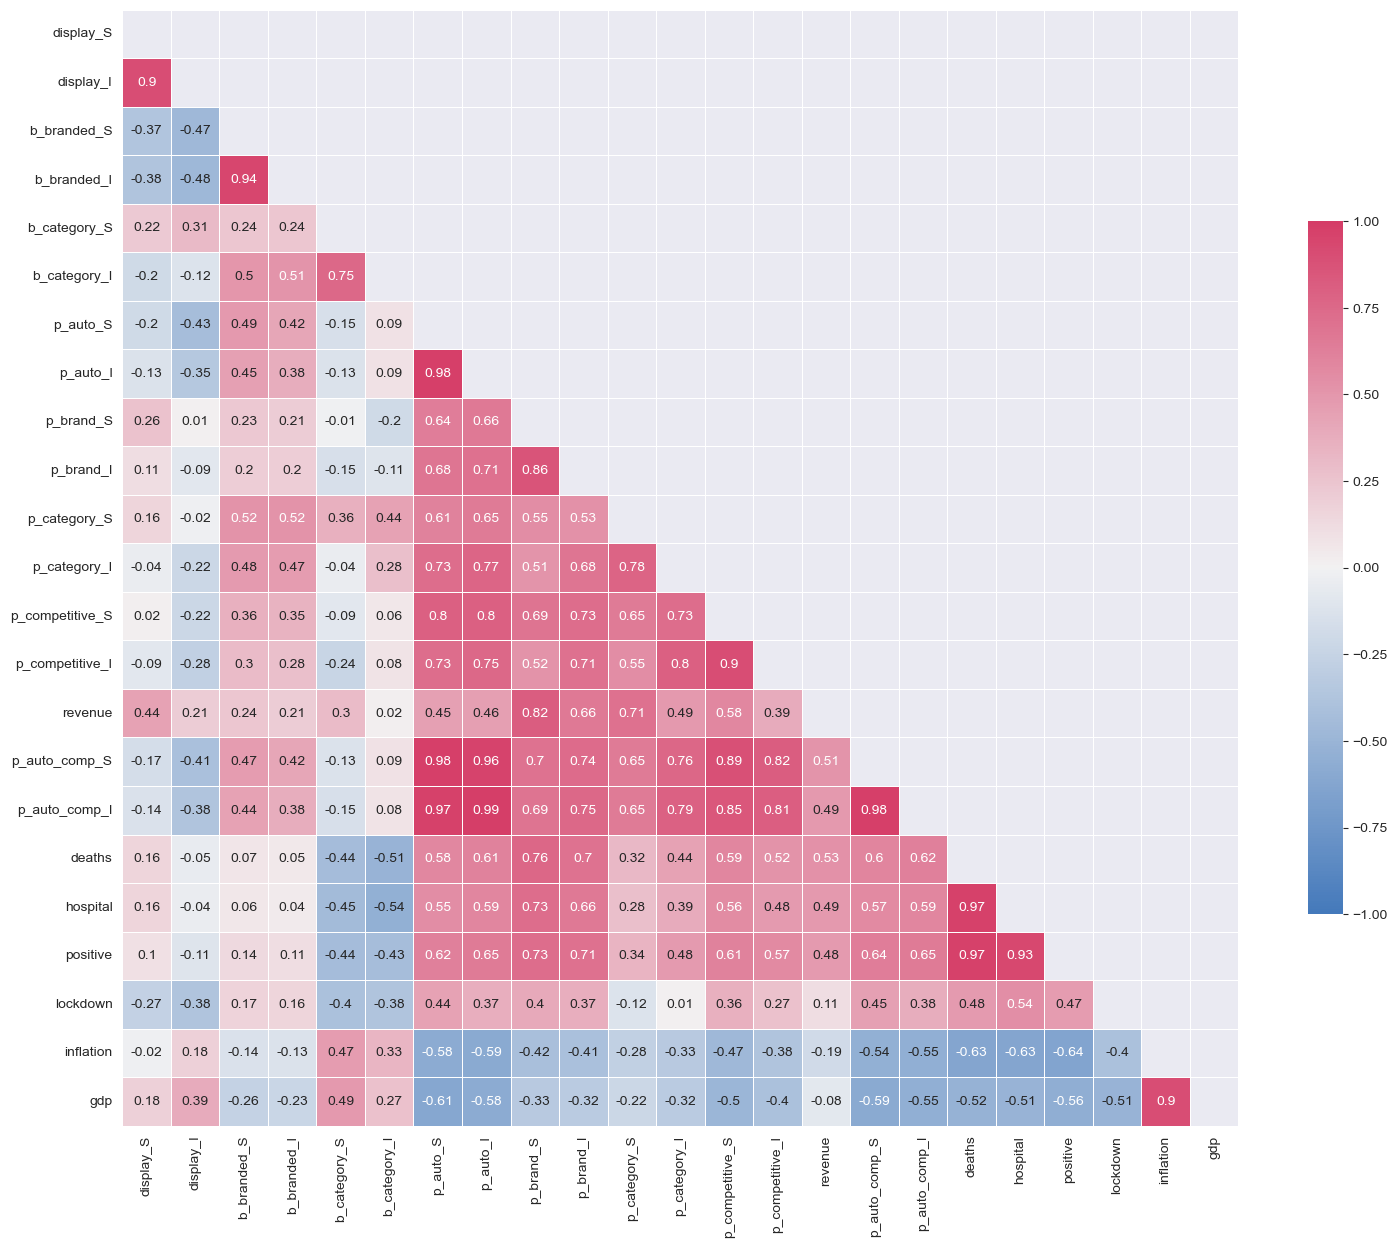

In [26]:
corr = df.corr(method="spearman").round(2)
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(18, 18))
cmap = sns.diverging_palette(250, 1, as_cmap=True)
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
corr.describe()

AttributeError: 'numpy.ndarray' object has no attribute 'set_xlabel'

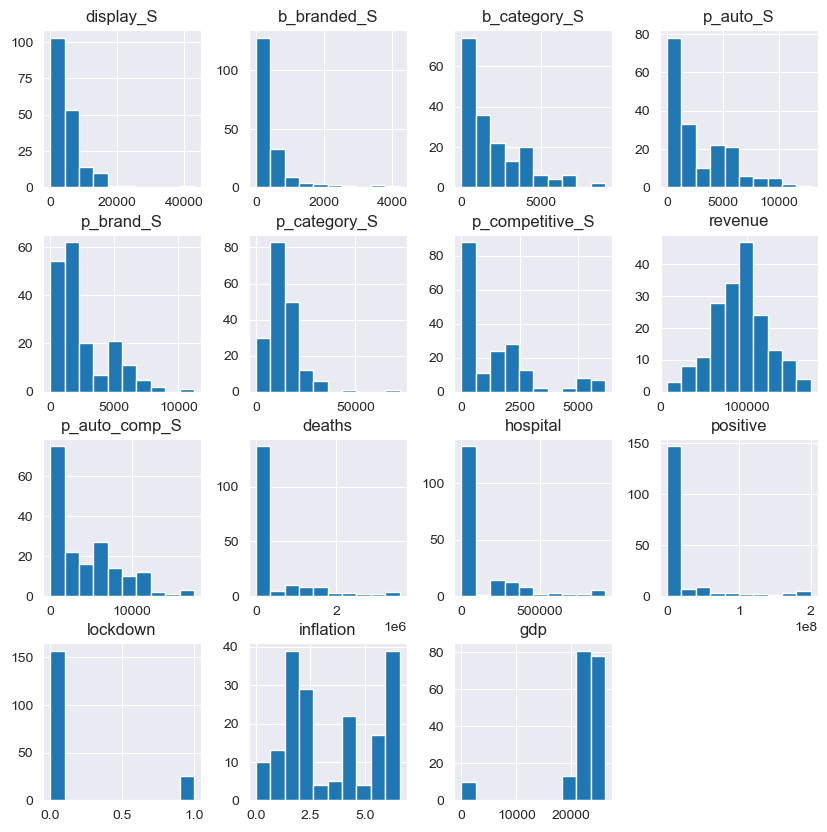

In [27]:
ax = df_spend.hist(grid=True, figsize=(10,10))
ax.set_xlabel("Session Duration (Seconds)")

,display_S,b_branded_S,b_category_S,p_auto_S,p_brand_S,p_category_S,p_competitive_S,revenue,p_auto_comp_S,deaths,hospital,positive,lockdown,inflation,gdp
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,0.111333,0.214667,0.064667,0.374667,0.450000,0.368667,0.403333,0.426000,0.402000,0.362667,0.350000,0.359333,0.181333,-0.171333,-0.141333
std,0.329759,0.340060,0.424363,0.514571,0.424466,0.363335,0.462859,0.316291,0.514396,0.536929,0.530566,0.539927,0.434558,0.542071,0.540408
min,-0.370000,-0.370000,-0.450000,-0.610000,-0.420000,-0.280000,-0.500000,-0.190000,-0.590000,-0.630000,-0.630000,-0.640000,-0.510000,-0.640000,-0.610000
25%,-0.095000,0.065000,-0.275000,0.145000,0.245000,0.220000,0.190000,0.270000,0.160000,0.115000,0.110000,0.120000,-0.195000,-0.560000,-0.515000
50%,0.160000,0.230000,-0.010000,0.550000,0.640000,0.360000,0.580000,0.480000,0.570000,0.530000,0.540000,0.480000,0.360000,-0.400000,-0.330000
75%,0.200000,0.415000,0.330000,0.630000,0.730000,0.630000,0.670000,0.555000,0.675000,0.680000,0.650000,0.685000,0.460000,-0.080000,0.050000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


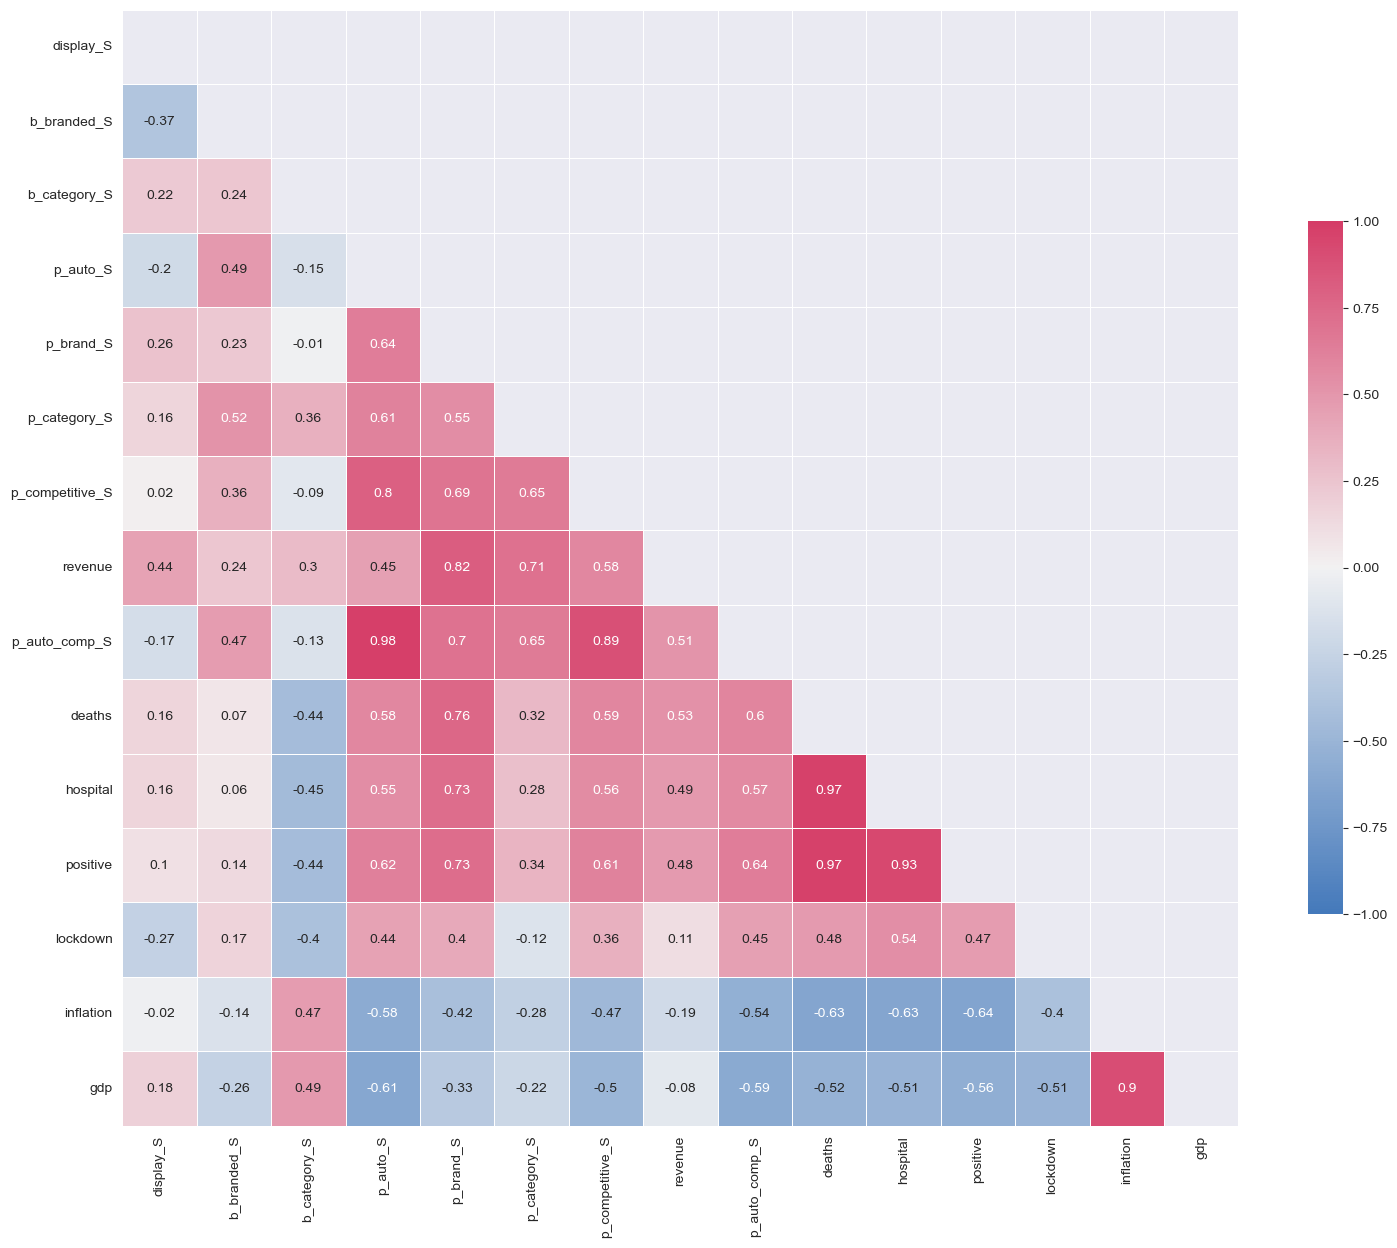

In [28]:
corr = df_spend.corr(method="spearman").round(2)
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(18, 18))
cmap = sns.diverging_palette(250, 1, as_cmap=True)
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
corr.describe()

,revenue,deaths,hospital,positive,lockdown,inflation,gdp
count,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
mean,0.334286,0.400000,0.398571,0.378571,0.241429,-0.084286,-0.040000
std,0.413072,0.700048,0.693119,0.704401,0.542692,0.725692,0.696348
min,-0.190000,-0.630000,-0.630000,-0.640000,-0.510000,-0.640000,-0.560000
25%,0.015000,-0.020000,-0.010000,-0.045000,-0.145000,-0.630000,-0.515000
50%,0.480000,0.530000,0.540000,0.480000,0.470000,-0.400000,-0.510000
75%,0.510000,0.970000,0.950000,0.950000,0.510000,0.355000,0.410000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


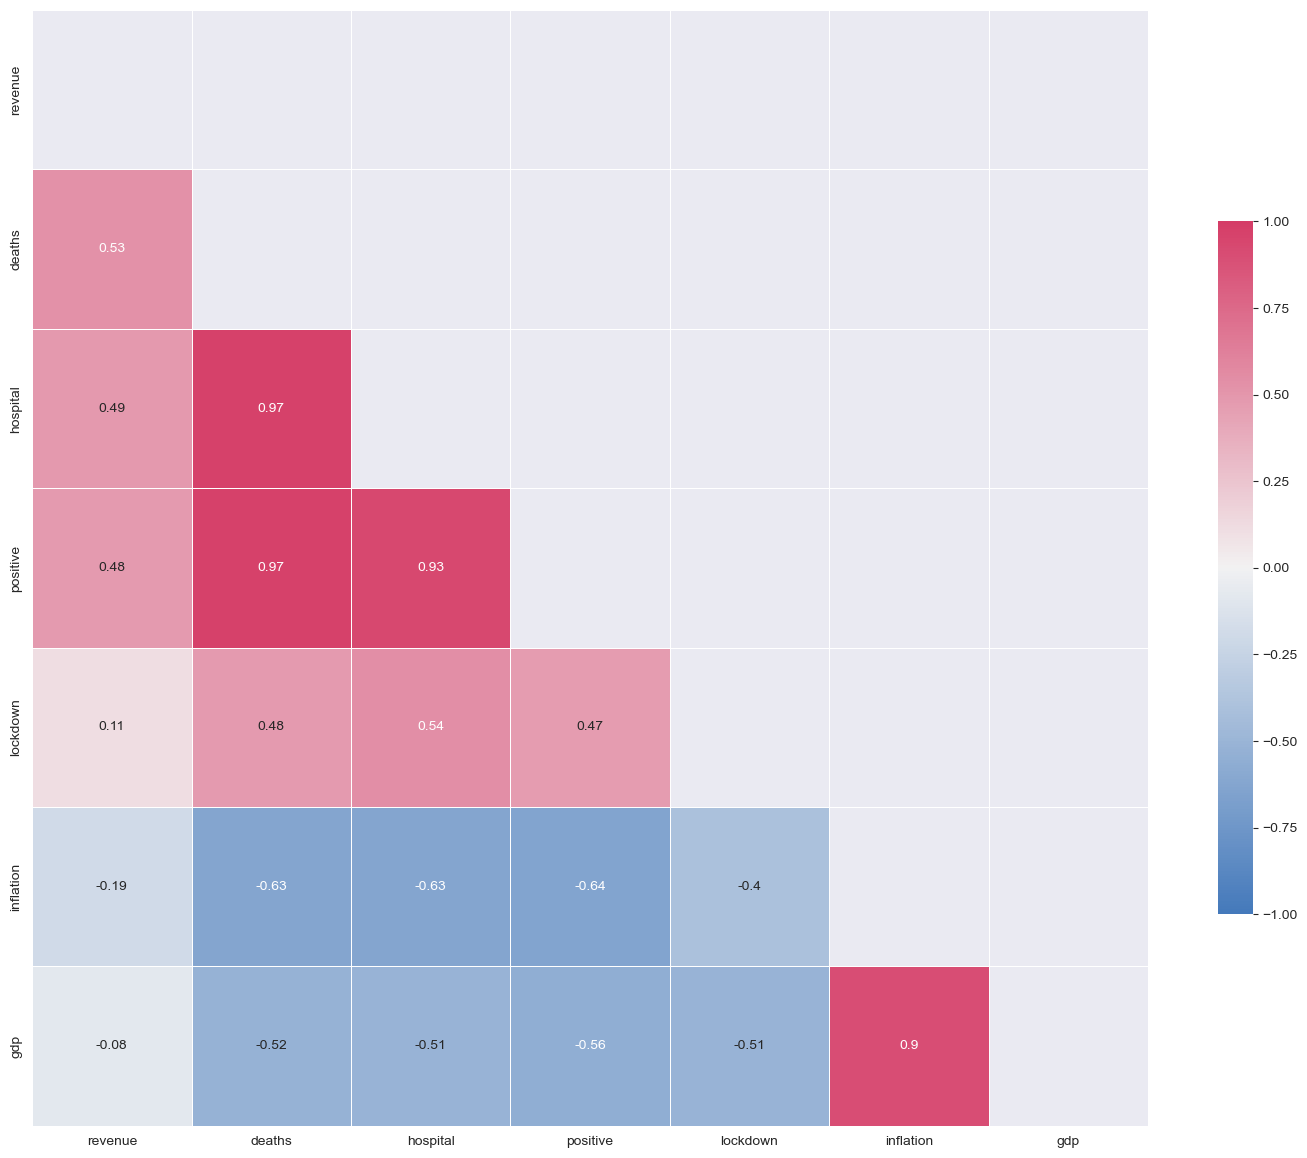

In [29]:
corr = df_context.corr(method="spearman").round(2)
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(18, 18))
cmap = sns.diverging_palette(250, 1, as_cmap=True)
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
corr.describe()